## Context
You are working with the government to transform your city into a smart city. The vision is to convert it into a digital and intelligent city to improve the efficiency of services for the citizens. One of the problems faced by the government is traffic. You are a data scientist working to manage the traffic of the city better and to provide input on infrastructure planning for the future.

The government wants to implement a robust traffic system for the city by being prepared for traffic peaks. They want to understand the traffic patterns of the four junctions of the city. Traffic patterns on holidays, as well as on various other occasions during the year, differ from normal working days. This is important to take into account for your forecasting.

## Content
To predict traffic patterns in each of these four junctions for the next 4 months.

The sensors on each of these junctions were collecting data at different times, hence you will see traffic data from different time periods. To add to the complexity, some of the junctions have provided limited or sparse data requiring thoughtfulness when creating future projections. Depending upon the historical data of 20 months, the government is looking to you to deliver accurate traffic projections for the coming four months. Your algorithm will become the foundation of a larger transformation to make your city smart and intelligent.

In [271]:
import pandas as pd
import numpy as np
import gc
from datetime import datetime
import time
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import catboost as cb
import optuna

## Data loadind

In [2]:
train = pd.read_csv('train_ML_IOT.csv', parse_dates=['DateTime'])
test = pd.read_csv('test_ML_IOT.csv', parse_dates=['DateTime'])

In [3]:
train.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [25]:
test.head()

,DateTime,Junction,ID
0,2017-07-01 00:00:00,1,20170701001
1,2017-07-01 01:00:00,1,20170701011
2,2017-07-01 02:00:00,1,20170701021
3,2017-07-01 03:00:00,1,20170701031
4,2017-07-01 04:00:00,1,20170701041


## Exploratory Data Analysis

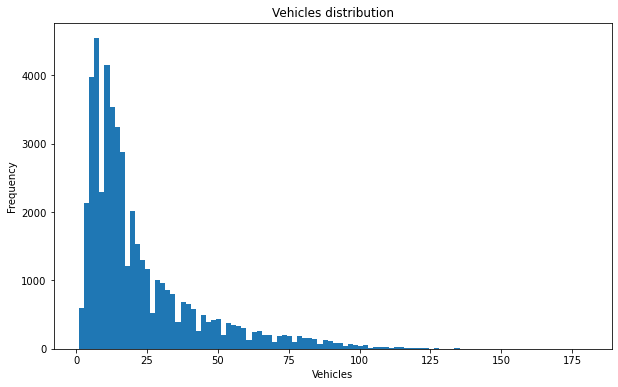

In [143]:
plt.figure(figsize=(10,6))
train.Vehicles.plot(kind='hist', bins=100, title = 'Vehicles distribution')
plt.xlabel('Vehicles')
plt.show()

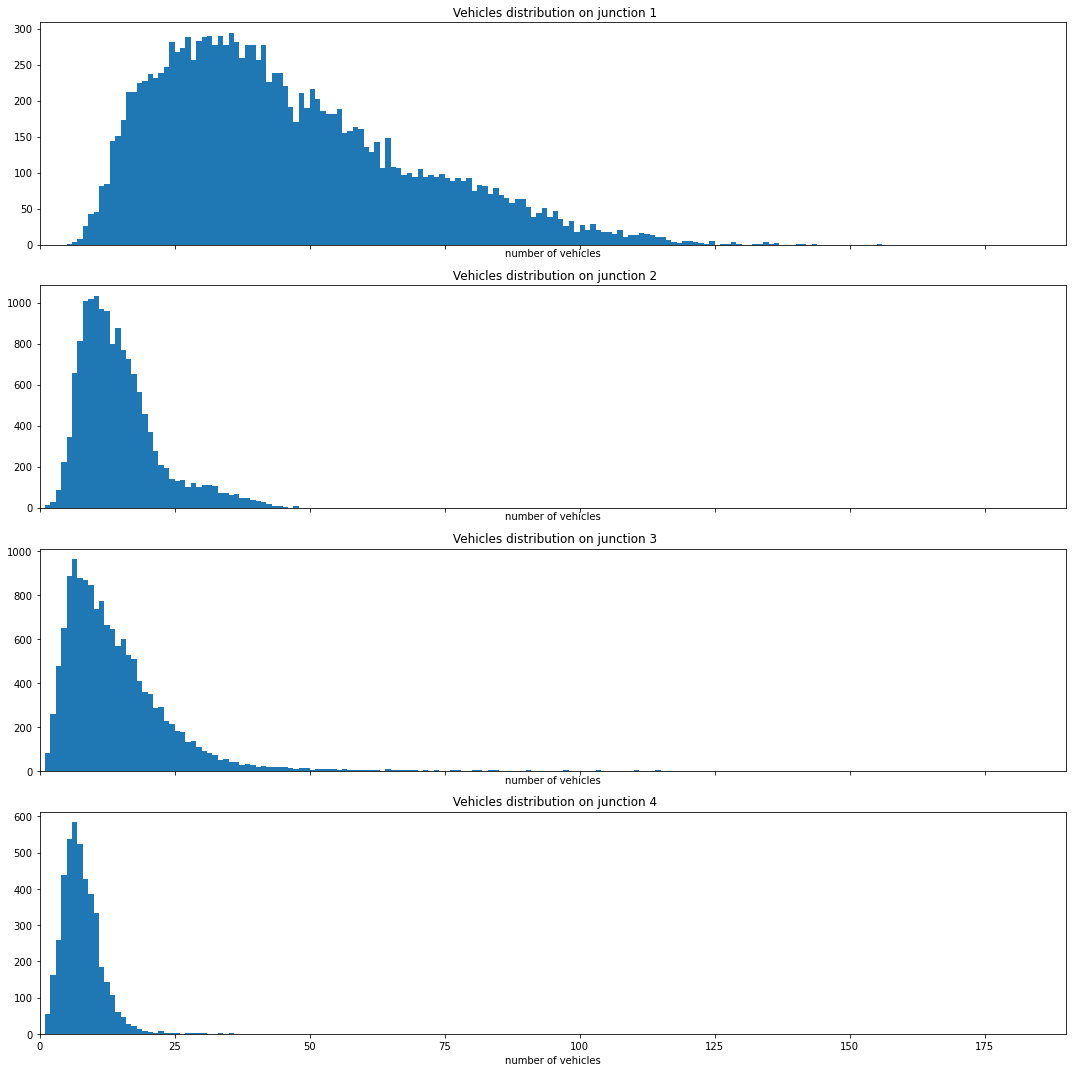

In [244]:
f, axes = plt.subplots(nrows=4, ncols=1, sharex='col', sharey='row', figsize=(15,15))
for i in range(0, len(train.Junction.unique())):
    data = train[train['Junction'] == i+1].Vehicles
    axes[i].hist(data, bins =range(min(data), max(data)+1,1))
    axes[i].set_title(f' Vehicles distribution on junction {i+1}')
    axes[i].set_xlabel('number of vehicles')
    axes[i].set_xlim([0,190])
plt.tight_layout()
plt.show()

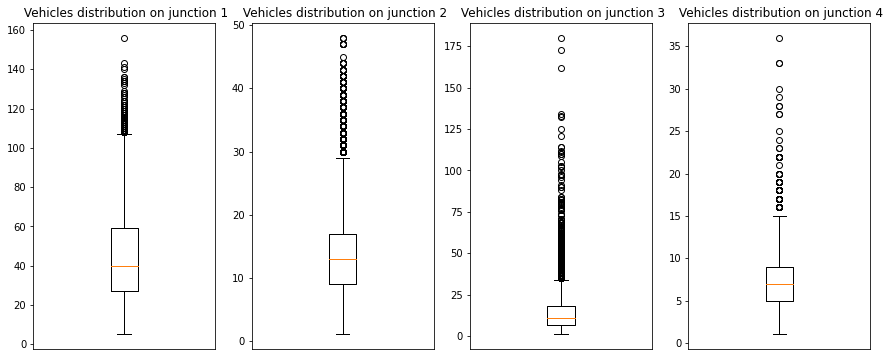

In [248]:
f, axes = plt.subplots(1, 4, figsize=(15,6))
for i in range(0, len(train.Junction.unique())):
    data = train[train['Junction'] == i+1].Vehicles
    axes[i].boxplot(data)
    axes[i].set_title(f' Vehicles distribution on junction {i+1}')
    axes[i].set_xticks([0])
plt.show()

In [19]:
print("first date in train set ", train.DateTime.min())
print("last date in train seth ", train.DateTime.max())
print("whole train period ", (train.DateTime.max() - train.DateTime.min()))

first date in train set  2015-11-01 00:00:00
last date in train seth  2017-06-30 23:00:00
whole train period  607 days 23:00:00


In [20]:
print("first date in test set ", test.DateTime.min())
print("last date in test seth ", test.DateTime.max())
print("whole test period ", (test.DateTime.max() - test.DateTime.min()))

first date in test set  2017-07-01 00:00:00
last date in test seth  2017-10-31 23:00:00
whole test period  122 days 23:00:00


In [21]:
train.describe()

,Junction,Vehicles,ID
count,48120.000000,48120.000000,4.812000e+04
mean,2.180549,22.791334,2.016330e+10
std,0.966955,20.750063,5.944854e+06
min,1.000000,1.000000,2.015110e+10
25%,1.000000,9.000000,2.016042e+10
50%,2.000000,15.000000,2.016093e+10
75%,3.000000,29.000000,2.017023e+10
max,4.000000,180.000000,2.017063e+10


ID culomn has the same information as DateTime column. And we can easyly drop it

In [26]:
train.drop(["ID"],axis = 1,inplace=True)
test_ID = test["ID"]
test.drop(["ID"],axis = 1,inplace=True)

Creating new features from DateTime column

In [217]:
train['year'] = [date.year for date in train.DateTime]
train['month'] = [date.month for date in train.DateTime]
train['day'] = [date.day for date in train.DateTime]
train['weekday'] = [datetime.weekday(date) for date in train.DateTime]
train['hour'] = [date.hour for date in train.DateTime]
train['weekend'] = [date > 4 for date in train.weekday]
train['weekend'] = train['weekend'].astype(int)

test['year'] = [date.year for date in test.DateTime]
test['month'] = [date.month for date in test.DateTime]
test['day'] = [date.day for date in test.DateTime]
test['weekday'] = [datetime.weekday(date) for date in test.DateTime]
test['hour'] = [date.hour for date in test.DateTime]
test['weekend'] = [date > 4 for date in test.weekday]
test['weekend'] = test['weekend'].astype(int)

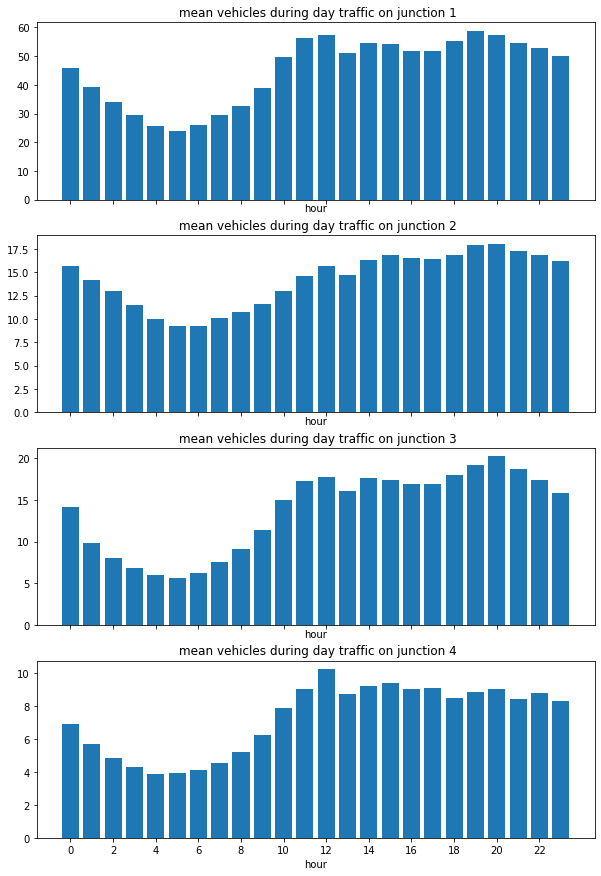

In [241]:
mean_vehicles = train.groupby(['hour', 'Junction'], as_index=False)['Vehicles'].mean()
f, axes = plt.subplots(4, 1, sharex='col', figsize=(10,15))
for i in range(0, len(train.Junction.unique())):
    data = mean_vehicles[mean_vehicles['Junction'] == i+1]
    axes[i].bar(data.hour, data.Vehicles)
    axes[i].set_title(f' mean vehicles during day traffic on junction {i+1}')
    axes[i].set_xticks(range(0,24,2))
    axes[i].set_xlabel('hour')
    axes[i].set_xticklabels(range(0, 24, 2))
    
# plt.setp(axes, yticks=range(0, 60, 10), yticklabels=range(0, 60, 5))
plt.show()

In [278]:
y = train.Vehicles
X = train.drop(['DateTime', 'Vehicles'], axis=1)

In [314]:
test = test.drop('DateTime', axis=1)
test = pd.get_dummies(test, columns=test.columns.drop('weekend'))
test.head()

,weekend,Junction_1,Junction_2,Junction_3,Junction_4,year_2017,month_7,month_8,month_9,month_10,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,1,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [281]:
X = pd.get_dummies(X, columns=X.columns.drop('weekend'))

In [283]:
cat_features = X.columns

In [327]:
col = ['weekend', 'Junction_1', 'Junction_2', 'Junction_3', 'Junction_4', 'day_1', 'day_2', 'day_3', 'day_4',
       'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'day_10', 'day_11',
       'day_12', 'day_13', 'day_14', 'day_15', 'day_16', 'day_17', 'day_18',
       'day_19', 'day_20', 'day_21', 'day_22', 'day_23', 'day_24', 'day_25',
       'day_26', 'day_27', 'day_28', 'day_29', 'day_30', 'day_31', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5',
       'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23']

## Build and train model

In [310]:
def objective(trial):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state = 23)
    params = {
        'iterations': trial.suggest_int('iterations', 100, 10000),
        'learning_rate':trial.suggest_loguniform('learning_rate', 1e-4, 1.0),
        'depth':trial.suggest_int('depth', 2, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100),
        'cat_features':cat_features,
        'loss_function':'RMSE',
        'use_best_model':True,
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 1e-2, 10.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100)
    }
    
    model = cb.CatBoostRegressor(**params)
    model.fit(X_train, y_train, eval_set = [(X_val, y_val)], verbose = 0, early_stopping_rounds=500)
    y_pred = model.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    return score
    

In [311]:
%%time
study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 40)

[I 2021-03-08 00:49:55,172] A new study created in memory with name: no-name-4952089e-bdb3-4514-82a5-739418aeaee9
[I 2021-03-08 00:52:25,011] Trial 0 finished with value: 10.590646451398642 and parameters: {'iterations': 6264, 'learning_rate': 0.00026326313203316984, 'depth': 6, 'l2_leaf_reg': 0.12068181237942714, 'bagging_temperature': 0.09594812428667007, 'min_child_samples': 98}. Best is trial 0 with value: 10.590646451398642.
[I 2021-03-08 00:54:22,864] Trial 1 finished with value: 5.036499863216482 and parameters: {'iterations': 3984, 'learning_rate': 0.02290958803678513, 'depth': 7, 'l2_leaf_reg': 1.1835190779839086e-06, 'bagging_temperature': 0.024851048637107354, 'min_child_samples': 81}. Best is trial 1 with value: 5.036499863216482.
[I 2021-03-08 00:56:13,639] Trial 2 finished with value: 5.179456381379591 and parameters: {'iterations': 5360, 'learning_rate': 0.030472158437781435, 'depth': 5, 'l2_leaf_reg': 0.005061291437905482, 'bagging_temperature': 6.081470688604074, 'min_

[I 2021-03-08 01:34:19,940] Trial 25 finished with value: 4.714797057301554 and parameters: {'iterations': 4455, 'learning_rate': 0.19735043038492933, 'depth': 8, 'l2_leaf_reg': 84.19131808977741, 'bagging_temperature': 0.5545450853749786, 'min_child_samples': 26}. Best is trial 14 with value: 4.672791658131819.
[I 2021-03-08 01:36:38,435] Trial 26 finished with value: 5.00519616517734 and parameters: {'iterations': 7474, 'learning_rate': 0.04293858232982923, 'depth': 8, 'l2_leaf_reg': 79.536361561868, 'bagging_temperature': 0.22099038850985356, 'min_child_samples': 44}. Best is trial 14 with value: 4.672791658131819.
[I 2021-03-08 01:37:32,559] Trial 27 finished with value: 5.022814531968027 and parameters: {'iterations': 4323, 'learning_rate': 0.2445626628436332, 'depth': 6, 'l2_leaf_reg': 0.32481486340014254, 'bagging_temperature': 3.533889413557943, 'min_child_samples': 27}. Best is trial 14 with value: 4.672791658131819.
[I 2021-03-08 01:38:30,367] Trial 28 finished with value: 4.

Wall time: 1h 4min 54s


In [312]:
trial = study.best_trial
print(f"Best RMSE = {trial.value}")
print("Best params: ")
for k, v in trial.params.items():
    print(f"        {k} : {v}")

Best RMSE = 4.672791658131819
Best params: 
        iterations : 1753
        learning_rate : 0.8388680638722206
        depth : 10
        l2_leaf_reg : 30.546871805017858
        bagging_temperature : 0.44370831570124003
        min_child_samples : 60


In [329]:
params={
    'iterations' : 1753,
    'learning_rate' : 0.8388680638722206,
    'depth' : 10,
    'l2_leaf_reg' : 30.546871805017858,
    'bagging_temperature' : 0.44370831570124003,
    'min_child_samples' : 60,
    'cat_features':col,
    'loss_function':'RMSE'
}
model = cb.CatBoostRegressor(**params)
model.fit(X[col],y)
y_pred = model.predict(test[col])

0:	learn: 13.3414890	total: 47.7ms	remaining: 1m 23s
1:	learn: 12.0978860	total: 73.2ms	remaining: 1m 4s
2:	learn: 11.8998584	total: 95.7ms	remaining: 55.8s
3:	learn: 11.7466565	total: 119ms	remaining: 51.9s
4:	learn: 11.5563810	total: 142ms	remaining: 49.5s
5:	learn: 11.2876004	total: 165ms	remaining: 48.1s
6:	learn: 11.0954575	total: 190ms	remaining: 47.5s
7:	learn: 10.8962318	total: 214ms	remaining: 46.7s
8:	learn: 10.7508369	total: 247ms	remaining: 47.9s
9:	learn: 10.5564395	total: 270ms	remaining: 47.1s
10:	learn: 10.4922022	total: 292ms	remaining: 46.3s
11:	learn: 10.4076891	total: 315ms	remaining: 45.7s
12:	learn: 10.3538066	total: 339ms	remaining: 45.3s
13:	learn: 10.3224258	total: 365ms	remaining: 45.3s
14:	learn: 10.2240769	total: 393ms	remaining: 45.5s
15:	learn: 10.1088950	total: 415ms	remaining: 45.1s
16:	learn: 10.0362793	total: 441ms	remaining: 45s
17:	learn: 9.9964292	total: 476ms	remaining: 45.9s
18:	learn: 9.9630248	total: 512ms	remaining: 46.7s
19:	learn: 9.9110411	t

165:	learn: 9.3339839	total: 4.24s	remaining: 40.5s
166:	learn: 9.3329118	total: 4.26s	remaining: 40.5s
167:	learn: 9.3317738	total: 4.28s	remaining: 40.4s
168:	learn: 9.3306611	total: 4.3s	remaining: 40.4s
169:	learn: 9.3295337	total: 4.33s	remaining: 40.3s
170:	learn: 9.3284042	total: 4.35s	remaining: 40.2s
171:	learn: 9.3276878	total: 4.37s	remaining: 40.2s
172:	learn: 9.3264054	total: 4.39s	remaining: 40.1s
173:	learn: 9.3252857	total: 4.42s	remaining: 40.1s
174:	learn: 9.3243629	total: 4.44s	remaining: 40.1s
175:	learn: 9.3234186	total: 4.46s	remaining: 40s
176:	learn: 9.3222958	total: 4.48s	remaining: 39.9s
177:	learn: 9.3211831	total: 4.51s	remaining: 39.9s
178:	learn: 9.3200289	total: 4.54s	remaining: 39.9s
179:	learn: 9.3192108	total: 4.56s	remaining: 39.8s
180:	learn: 9.3181479	total: 4.58s	remaining: 39.8s
181:	learn: 9.3172652	total: 4.61s	remaining: 39.8s
182:	learn: 9.3164751	total: 4.63s	remaining: 39.7s
183:	learn: 9.3157576	total: 4.65s	remaining: 39.7s
184:	learn: 9.3

325:	learn: 9.2229606	total: 8s	remaining: 35s
326:	learn: 9.2224155	total: 8.03s	remaining: 35s
327:	learn: 9.2219781	total: 8.05s	remaining: 35s
328:	learn: 9.2215208	total: 8.08s	remaining: 35s
329:	learn: 9.2210920	total: 8.1s	remaining: 34.9s
330:	learn: 9.2205642	total: 8.12s	remaining: 34.9s
331:	learn: 9.2201812	total: 8.15s	remaining: 34.9s
332:	learn: 9.2197064	total: 8.18s	remaining: 34.9s
333:	learn: 9.2193258	total: 8.2s	remaining: 34.8s
334:	learn: 9.2187772	total: 8.22s	remaining: 34.8s
335:	learn: 9.2182673	total: 8.24s	remaining: 34.7s
336:	learn: 9.2179063	total: 8.26s	remaining: 34.7s
337:	learn: 9.2174713	total: 8.29s	remaining: 34.7s
338:	learn: 9.2169848	total: 8.32s	remaining: 34.7s
339:	learn: 9.2163184	total: 8.35s	remaining: 34.7s
340:	learn: 9.2158904	total: 8.37s	remaining: 34.7s
341:	learn: 9.2155427	total: 8.43s	remaining: 34.8s
342:	learn: 9.2151151	total: 8.46s	remaining: 34.8s
343:	learn: 9.2145755	total: 8.48s	remaining: 34.7s
344:	learn: 9.2142922	tot

489:	learn: 9.1627900	total: 12s	remaining: 31s
490:	learn: 9.1625782	total: 12s	remaining: 31s
491:	learn: 9.1624040	total: 12.1s	remaining: 30.9s
492:	learn: 9.1621356	total: 12.1s	remaining: 31s
493:	learn: 9.1619305	total: 12.2s	remaining: 31s
494:	learn: 9.1615175	total: 12.2s	remaining: 31s
495:	learn: 9.1613139	total: 12.2s	remaining: 30.9s
496:	learn: 9.1610618	total: 12.2s	remaining: 30.9s
497:	learn: 9.1608329	total: 12.2s	remaining: 30.9s
498:	learn: 9.1606188	total: 12.3s	remaining: 30.8s
499:	learn: 9.1603388	total: 12.3s	remaining: 30.8s
500:	learn: 9.1601337	total: 12.3s	remaining: 30.8s
501:	learn: 9.1599022	total: 12.3s	remaining: 30.7s
502:	learn: 9.1596831	total: 12.4s	remaining: 30.7s
503:	learn: 9.1594436	total: 12.4s	remaining: 30.7s
504:	learn: 9.1592224	total: 12.4s	remaining: 30.7s
505:	learn: 9.1589819	total: 12.4s	remaining: 30.6s
506:	learn: 9.1587137	total: 12.5s	remaining: 30.6s
507:	learn: 9.1584609	total: 12.5s	remaining: 30.6s
508:	learn: 9.1582517	tota

650:	learn: 9.1281178	total: 16.2s	remaining: 27.4s
651:	learn: 9.1278740	total: 16.2s	remaining: 27.3s
652:	learn: 9.1276557	total: 16.2s	remaining: 27.3s
653:	learn: 9.1274560	total: 16.3s	remaining: 27.3s
654:	learn: 9.1271945	total: 16.3s	remaining: 27.3s
655:	learn: 9.1270645	total: 16.3s	remaining: 27.3s
656:	learn: 9.1269136	total: 16.3s	remaining: 27.3s
657:	learn: 9.1268036	total: 16.4s	remaining: 27.2s
658:	learn: 9.1266482	total: 16.4s	remaining: 27.2s
659:	learn: 9.1264053	total: 16.4s	remaining: 27.2s
660:	learn: 9.1262574	total: 16.4s	remaining: 27.2s
661:	learn: 9.1261633	total: 16.5s	remaining: 27.2s
662:	learn: 9.1260146	total: 16.5s	remaining: 27.1s
663:	learn: 9.1258525	total: 16.5s	remaining: 27.1s
664:	learn: 9.1257443	total: 16.6s	remaining: 27.1s
665:	learn: 9.1255700	total: 16.6s	remaining: 27.1s
666:	learn: 9.1254251	total: 16.6s	remaining: 27.1s
667:	learn: 9.1252542	total: 16.6s	remaining: 27s
668:	learn: 9.1250817	total: 16.7s	remaining: 27s
669:	learn: 9.12

809:	learn: 9.1045581	total: 20s	remaining: 23.3s
810:	learn: 9.1044261	total: 20s	remaining: 23.2s
811:	learn: 9.1042876	total: 20s	remaining: 23.2s
812:	learn: 9.1041413	total: 20.1s	remaining: 23.2s
813:	learn: 9.1040642	total: 20.1s	remaining: 23.2s
814:	learn: 9.1039644	total: 20.1s	remaining: 23.1s
815:	learn: 9.1038470	total: 20.1s	remaining: 23.1s
816:	learn: 9.1037253	total: 20.2s	remaining: 23.1s
817:	learn: 9.1035660	total: 20.2s	remaining: 23.1s
818:	learn: 9.1034288	total: 20.2s	remaining: 23.1s
819:	learn: 9.1033069	total: 20.2s	remaining: 23s
820:	learn: 9.1031767	total: 20.3s	remaining: 23s
821:	learn: 9.1030576	total: 20.3s	remaining: 23s
822:	learn: 9.1029298	total: 20.3s	remaining: 22.9s
823:	learn: 9.1027972	total: 20.3s	remaining: 22.9s
824:	learn: 9.1026437	total: 20.3s	remaining: 22.9s
825:	learn: 9.1025350	total: 20.4s	remaining: 22.9s
826:	learn: 9.1024015	total: 20.4s	remaining: 22.8s
827:	learn: 9.1023028	total: 20.4s	remaining: 22.8s
828:	learn: 9.1021825	to

970:	learn: 9.0875297	total: 24s	remaining: 19.4s
971:	learn: 9.0874587	total: 24.1s	remaining: 19.3s
972:	learn: 9.0873621	total: 24.1s	remaining: 19.3s
973:	learn: 9.0872496	total: 24.1s	remaining: 19.3s
974:	learn: 9.0871722	total: 24.1s	remaining: 19.3s
975:	learn: 9.0870601	total: 24.2s	remaining: 19.2s
976:	learn: 9.0869806	total: 24.2s	remaining: 19.2s
977:	learn: 9.0869337	total: 24.2s	remaining: 19.2s
978:	learn: 9.0868663	total: 24.3s	remaining: 19.2s
979:	learn: 9.0867660	total: 24.3s	remaining: 19.2s
980:	learn: 9.0866776	total: 24.3s	remaining: 19.1s
981:	learn: 9.0865787	total: 24.4s	remaining: 19.1s
982:	learn: 9.0864360	total: 24.4s	remaining: 19.1s
983:	learn: 9.0863261	total: 24.4s	remaining: 19.1s
984:	learn: 9.0862595	total: 24.4s	remaining: 19.1s
985:	learn: 9.0861841	total: 24.5s	remaining: 19s
986:	learn: 9.0861280	total: 24.5s	remaining: 19s
987:	learn: 9.0860611	total: 24.5s	remaining: 19s
988:	learn: 9.0859810	total: 24.6s	remaining: 19s
989:	learn: 9.0858934	

1127:	learn: 9.0755329	total: 27.7s	remaining: 15.4s
1128:	learn: 9.0754730	total: 27.7s	remaining: 15.3s
1129:	learn: 9.0754182	total: 27.8s	remaining: 15.3s
1130:	learn: 9.0753293	total: 27.8s	remaining: 15.3s
1131:	learn: 9.0752739	total: 27.8s	remaining: 15.3s
1132:	learn: 9.0752129	total: 27.8s	remaining: 15.2s
1133:	learn: 9.0751560	total: 27.9s	remaining: 15.2s
1134:	learn: 9.0750880	total: 27.9s	remaining: 15.2s
1135:	learn: 9.0750165	total: 27.9s	remaining: 15.2s
1136:	learn: 9.0749508	total: 27.9s	remaining: 15.1s
1137:	learn: 9.0748723	total: 28s	remaining: 15.1s
1138:	learn: 9.0748135	total: 28s	remaining: 15.1s
1139:	learn: 9.0747561	total: 28s	remaining: 15.1s
1140:	learn: 9.0747140	total: 28s	remaining: 15s
1141:	learn: 9.0746229	total: 28s	remaining: 15s
1142:	learn: 9.0745767	total: 28.1s	remaining: 15s
1143:	learn: 9.0745435	total: 28.1s	remaining: 14.9s
1144:	learn: 9.0744575	total: 28.1s	remaining: 14.9s
1145:	learn: 9.0743587	total: 28.1s	remaining: 14.9s
1146:	lea

1284:	learn: 9.0665226	total: 31.2s	remaining: 11.4s
1285:	learn: 9.0664801	total: 31.2s	remaining: 11.3s
1286:	learn: 9.0664259	total: 31.2s	remaining: 11.3s
1287:	learn: 9.0663872	total: 31.3s	remaining: 11.3s
1288:	learn: 9.0663399	total: 31.3s	remaining: 11.3s
1289:	learn: 9.0662897	total: 31.3s	remaining: 11.2s
1290:	learn: 9.0662593	total: 31.3s	remaining: 11.2s
1291:	learn: 9.0662107	total: 31.3s	remaining: 11.2s
1292:	learn: 9.0661487	total: 31.4s	remaining: 11.2s
1293:	learn: 9.0660969	total: 31.4s	remaining: 11.1s
1294:	learn: 9.0660678	total: 31.4s	remaining: 11.1s
1295:	learn: 9.0659947	total: 31.4s	remaining: 11.1s
1296:	learn: 9.0659561	total: 31.4s	remaining: 11.1s
1297:	learn: 9.0659076	total: 31.5s	remaining: 11s
1298:	learn: 9.0658697	total: 31.5s	remaining: 11s
1299:	learn: 9.0658158	total: 31.5s	remaining: 11s
1300:	learn: 9.0657876	total: 31.5s	remaining: 11s
1301:	learn: 9.0657419	total: 31.6s	remaining: 10.9s
1302:	learn: 9.0656770	total: 31.6s	remaining: 10.9s
1

1446:	learn: 9.0593503	total: 34.7s	remaining: 7.35s
1447:	learn: 9.0592798	total: 34.8s	remaining: 7.32s
1448:	learn: 9.0592345	total: 34.8s	remaining: 7.3s
1449:	learn: 9.0591774	total: 34.8s	remaining: 7.27s
1450:	learn: 9.0591137	total: 34.8s	remaining: 7.25s
1451:	learn: 9.0590895	total: 34.8s	remaining: 7.22s
1452:	learn: 9.0590543	total: 34.9s	remaining: 7.2s
1453:	learn: 9.0590182	total: 34.9s	remaining: 7.17s
1454:	learn: 9.0589649	total: 34.9s	remaining: 7.15s
1455:	learn: 9.0589207	total: 34.9s	remaining: 7.13s
1456:	learn: 9.0588943	total: 35s	remaining: 7.1s
1457:	learn: 9.0588520	total: 35s	remaining: 7.08s
1458:	learn: 9.0588130	total: 35s	remaining: 7.05s
1459:	learn: 9.0587791	total: 35s	remaining: 7.03s
1460:	learn: 9.0587574	total: 35s	remaining: 7s
1461:	learn: 9.0587333	total: 35.1s	remaining: 6.98s
1462:	learn: 9.0586984	total: 35.1s	remaining: 6.96s
1463:	learn: 9.0586729	total: 35.1s	remaining: 6.93s
1464:	learn: 9.0586522	total: 35.1s	remaining: 6.91s
1465:	lea

1607:	learn: 9.0538654	total: 38.4s	remaining: 3.46s
1608:	learn: 9.0538295	total: 38.4s	remaining: 3.44s
1609:	learn: 9.0538039	total: 38.4s	remaining: 3.41s
1610:	learn: 9.0537731	total: 38.5s	remaining: 3.39s
1611:	learn: 9.0537457	total: 38.5s	remaining: 3.37s
1612:	learn: 9.0537159	total: 38.5s	remaining: 3.34s
1613:	learn: 9.0536865	total: 38.5s	remaining: 3.32s
1614:	learn: 9.0536679	total: 38.5s	remaining: 3.29s
1615:	learn: 9.0536376	total: 38.6s	remaining: 3.27s
1616:	learn: 9.0536205	total: 38.6s	remaining: 3.25s
1617:	learn: 9.0535910	total: 38.6s	remaining: 3.22s
1618:	learn: 9.0535435	total: 38.6s	remaining: 3.2s
1619:	learn: 9.0535248	total: 38.7s	remaining: 3.17s
1620:	learn: 9.0535052	total: 38.7s	remaining: 3.15s
1621:	learn: 9.0534579	total: 38.7s	remaining: 3.13s
1622:	learn: 9.0534245	total: 38.7s	remaining: 3.1s
1623:	learn: 9.0533947	total: 38.7s	remaining: 3.08s
1624:	learn: 9.0533560	total: 38.8s	remaining: 3.05s
1625:	learn: 9.0533328	total: 38.8s	remaining: 3

In [337]:
submission = pd.DataFrame(data={'ID':test_ID.values, 'Vehicles':y_pred}, index=False)
submission.to_csv('catboost_optuna.csv')

TypeError: Index(...) must be called with a collection of some kind, False was passed

In [345]:
sub = pd.read_csv('sample_submission_ML_IOT.csv', index_col='ID')

In [346]:
sub['Vehicles']=y_pred

In [347]:
sub.to_csv('sub.csv')

In [348]:
sub

,Vehicles
ID,
20170701001,58.299070
20170701011,50.464268
20170701021,40.258259
20170701031,35.394461
20170701041,31.799883
...,...
20171031194,8.727686
20171031204,9.641343
20171031214,8.077971


In [ ]:
def objective_xgb(trial):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state = 23)
    params = {
        'n_estimators': trial.suggest_int('iterations', 100, 10000),
        'learning_rate':trial.suggest_loguniform('learning_rate', 1e-4, 0.3),
        'max_depth':trial.suggest_int('depth', 2, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 24)
        'subsample': trial.suggest_loguniform('subsample', 1e-4, 1),
        'loss_function':'RMSE',
        'use_best_model':True,
    }
    
    model = xgb.XGBoostRegressor(**params)
    model.fit(X_train, y_train, eval_set = [(X_val, y_val)], verbose = 0, early_stopping_rounds=500)
    y_pred = model.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    return score

In [ ]:
n_folds = 10
train_oof = np.zeros((300000,))
test_preds = 0

skf = KFold(n_splits=n_folds, random_state=23, shuffle=True)

for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    
    print(f'FOLD    {fold+1}')
    
    X_train, X_valid = pd.DataFrame(X.iloc[train_index]), pd.DataFrame(X.iloc[test_index])
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
       
    cat_params = { 
        'iterations': 7827,
        'depth': 6, 
        'learning_rate': 0.06115296942277834, 
        'l2_leaf_reg': 0.00018537808841101856, 
        'bagging_temperature': 7.2769130916283125, 
        'min_child_samples': 95
    }
    
    model = cb.CatBoostRegressor(
        **cat_params
    )
    model.fit(
        X_train, 
        y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=500,
        early_stopping_rounds=200,
    )
    preds = model.predict(X_valid)
    test_preds += model.predict(test) / n_folds
    train_oof[test_index] = preds
    print("")
    

print(f": RMSE = {mean_squared_error(y, train_oof)}")

submission['target'] = test_preds
submission.to_csv('catboost_optuna_scaled.csv')